<img src="../assets/header.gif"
     width="4000" 
     height="100"/>
<hr style="color:#c6cde1;">
<p align="center">
    <b style="font-size:2.5vw; color:#c6cde1; font-weight:bold;">
    Upper-level: Power flow formulations comparison
    </b>
</p>
<hr style="color:#c6cde1;">
<b>Description</b><br>
<p align="justify">
    The purpose of this notebook is to compare the DNEP formulations from the two papers
    <ul>
        <li style="margin-bottom:10px"> Jabr, R. A. (2012). Polyhedral formulations and loop elimination constraints for distribution network expansion planning. IEEE Transactions on Power Systems, 28(2), 1888-1897. and,</li>
        <li style="margin-bottom:10px"> Franco, J. F., Rider, M. J., & Romero, R. (2014). A mixed-integer quadratically-constrained programming model for the distribution system expansion planning. International Journal of Electrical Power & Energy Systems, 62, 265-272.</li>
    </ul> 
<br>
<b>Author</b><br><br> 
<i>Manon Cornet</i>

[comment]: <> (Section)
<hr style="color:#c6cde1;">
<p align="center">
    <b style="font-size:2vw; color:#c6cde1;">
    1. Initialization
    </b>
</p>
<hr style="color:#c6cde1;">

[comment]: <> (Description)
<p align="justify">
    In this section, one will be able to:
    <ul>
        <li style="margin-bottom:10px">Initialize all the librairies needed for the project;</li>
        <li style="margin-bottom:10px">Include the codes containing the two formulations</li>
    </ul> 

In [5]:
# -- LIBRAIRIES --#

import XLSX, DataFrames
using JuMP, Gurobi, Printf, Dates
using GraphRecipes, Graphs, Plots
using Test, PyPlot

In [6]:
# -- MODEL FILES --

include("UL_Jabr.jl")
include("UL_BFM.jl")

LoadError: LoadError: Expression if one_power
    #= /Users/manoncornet/Documents/University/TFE/DNEP/upper_level_manon/UL_BFM.jl:95 =#
    (P_ij_k[L, K], container = Array)
    #= /Users/manoncornet/Documents/University/TFE/DNEP/upper_level_manon/UL_BFM.jl:96 =#
    (Q_ij_k[L, K], container = Array)
end cannot be used as a name.
in expression starting at /Users/manoncornet/Documents/University/TFE/DNEP/upper_level_manon/UL_BFM.jl:94
in expression starting at /Users/manoncornet/Documents/University/TFE/DNEP/upper_level_manon/UL_BFM.jl:57

In [659]:
# -- FUNCTION TO PRINT TITLE --

function print_title(title::String)
    println(title)
    for i in 1:length(title) @printf("-") end
    @printf("\n")
end

print_title (generic function with 1 method)

In [660]:
# -- FUNCTION TO PRINT 1D ARRAY --
function print_vector(vector::Vector{<:Number}, units)
    println("["*join(vector, ", ")*"] [$units]")
end

print_vector (generic function with 1 method)

[comment]: <> (Section)
<hr style="color:#c6cde1;">
<p align="center">
    <b style="font-size:2vw; color:#c6cde1;">
    2. Definition of the network model 
    </b>
</p>
<hr style="color:#c6cde1;">

[comment]: <> (Description)
<p align="justify">
    In this section, one will be able to:
    <ul>
        <li style="margin-bottom:10px">Load a network model from an Excel file;</li>
        <li style="margin-bottom:10px">Initialize the parameters defining the network</li>
    </ul> 

In [661]:
# -- LOADING OF THE EXCEL FILE --

XLSX_FILE_PATH = joinpath(splitdir(@__DIR__)[1], "network_models/network_Nahman_Peric_2S23H.xlsx")

"/Users/manoncornet/Documents/University/TFE/DNEP/network_models/network_Nahman_Peric_2S23H.xlsx"

In [662]:
# -- DEFINITION OF THE PER UNIT BASIS --
# Values obtained by reading the Paper "A Constructive Heuristic Algorithm for Distribution System Planning"

const BASE_VOLTAGE    = 34.5                             # [kV]
const BASE_POWER      = 10                               # [MVA]
const BASE_CURRENT    = BASE_POWER / BASE_VOLTAGE        # [kA]
const BASE_ADMITTANCE = BASE_CURRENT / BASE_VOLTAGE      # [S]
const BASE_IMPEDANCE  = 1/BASE_ADMITTANCE                # [Ohm]
print_title("Per-unit basis:")

@printf("Base Admittance : %.3e [S]\n", BASE_ADMITTANCE)
@printf("Base Impedance  : %.3e [Ohm]\n", BASE_IMPEDANCE)
@printf("Base Voltage    : %.3e [kV]\n", BASE_VOLTAGE)
@printf("Base Current    : %.3e [kA]\n", BASE_CURRENT)
@printf("Base Power      : %.3e [MVA]\n", BASE_POWER)

Per-unit basis:
---------------
Base Admittance : 8.402e-03 [S]
Base Impedance  : 1.190e+02 [Ohm]
Base Voltage    : 3.450e+01 [kV]
Base Current    : 2.899e-01 [kA]
Base Power      : 1.000e+01 [MVA]


In [663]:
# -- FUNCTION THAT PROCESSES THE LINE PROPRETIES  --

function process_conductors(df_cond::DataFrames.DataFrame, 
                            len_lines::Vector{Float64},  
                            nb_lines::Integer, 
                        )

    nb_cond = DataFrames.nrow(df_cond)
    max_i   = Array{Float64}(undef, nb_lines, nb_cond) # absolute, [pu]
    r       = Array{Float64}(undef, nb_lines, nb_cond) # absolute, [pu]
    x       = Array{Float64}(undef, nb_lines, nb_cond) # absolute, [pu]
    g       = Array{Float64}(undef, nb_lines, nb_cond) # absolute, [pu]
    b       = Array{Float64}(undef, nb_lines, nb_cond) # absolute, [pu]
    
    line_cost = Array{Float64}(undef, nb_lines, nb_cond) # [€/km]

    # Only take the first conductors of the list in the file
    for l in 1:nb_lines
        for k in 1:nb_cond
            max_i[l, k] = df_cond.max_i_ka[k] ./ BASE_CURRENT

            r[l, k] = len_lines[l] * df_cond.r_ohm_per_km[k] ./ BASE_IMPEDANCE
            x[l, k] = len_lines[l] * df_cond.x_ohm_per_km[k] ./ BASE_IMPEDANCE
            y = 1/(r[l, k]+im*x[l, k])

            g[l, k] = real(y) 
            b[l, k] = abs(imag(y))

            line_cost[l, k] = df_cond.cost_kdollars_per_km[k] * len_lines[l]
        end
    end
    return max_i, line_cost, r, x, g, b
end

process_conductors (generic function with 1 method)

In [664]:
# -- FETCH THE DATA FROM THE EXCEL SHEET --

df_bus  = DataFrames.DataFrame(XLSX.readtable(XLSX_FILE_PATH, "bus"))
df_line = DataFrames.DataFrame(XLSX.readtable(XLSX_FILE_PATH, "line"))
df_cond = DataFrames.DataFrame(XLSX.readtable(XLSX_FILE_PATH, "conductor"))

Row,idx,Name,d_mm,q_mm2,r_ohm_per_km,x_ohm_per_km,max_i_ka,cost_kdollars_per_km
,Any,Any,Any,Any,Any,Any,Any,Any
1,1,AAC (1/0),9.35,53.5,0.5502,0.429,0.23,10
2,2,AAC (4/0),13.26,107.3,0.2707,0.402,0.34,20


In [665]:
# -- LINE PARAMETERS DEFINITION --

L_size = DataFrames.nrow(df_line)                                   # Number of lines in the network
L      = 1:L_size                                                   # Line set
line_ends = [(df_line.from_bus[l], df_line.to_bus[l]) for l in L]   # Indices of the line extremities
len_lines = convert(Vector{Float64}, df_line.length_km)             # Line lengths [km]

print_title("Network lines summary:")
@printf("Number of lines : %d\n", L_size)

Network lines summary:
----------------------
Number of lines : 34


In [666]:
# -- DEFINITION OF THE PHYSICAL QUANTITIES ASSOCIATED TO NETWORK LINES --

K_size = DataFrames.nrow(df_cond)   # Number of conductor types
K      = 1:K_size                   # Set of conductors

max_i, line_cost, R, X, G, B, = process_conductors(df_cond, len_lines, L_size)

print_title("Conductor properties:")
println(df_cond)

Conductor properties:
---------------------
2×8 DataFrame
 Row │ idx  Name       d_mm   q_mm2  r_ohm_per_km  x_ohm_per_km  max_i_ka  cost_kdollars_per_km 
     │ Any  Any        Any    Any    Any           Any           Any       Any                  
─────┼──────────────────────────────────────────────────────────────────────────────────────────
   1 │ 1    AAC (1/0)  9.35   53.5   0.5502        0.429         0.23      10
   2 │ 2    AAC (4/0)  13.26  107.3  0.2707        0.402         0.34      20


In [667]:
# -- BUS PARAMETERS DEFINITION --

N_size = DataFrames.nrow(df_bus)            # Number of buses in the network
N      = 1:N_size                           # Buses set

Ns_size = sum(df_bus.type .== "substation") # Number of substation buses
Nu_size = sum(df_bus.type .== "user")       # Number of load nodes

Ns = 1:Ns_size                              # Set of substation buses
Nu = (1:Nu_size) .+ Ns_size                 # Set of load buses

print_title("Network buses summary:")
@printf("Number of buses            : %d\n", N_size)
@printf("Number of load buses       : %d\n", Nu_size)
@printf("Number of substation buses : %d\n", Ns_size)

Network buses summary:
----------------------
Number of buses            : 23
Number of load buses       : 21
Number of substation buses : 2


In [668]:
# -- DEFINITION OF THE PHYSICAL QUANTITIES ASSOCIATED TO NETWORK BUSES --

# Limits on voltage
MIN_VOLTAGE = 0.97  # [pu]
MAX_VOLTAGE = 1.03  # [pu]

# Demand at buses
# Assumption: load power factor is constant for all loads and is lagging (inductive)
cos_phi = 0.9
S_D     = convert(Vector{Float64}, df_bus.S_D_mva) ./ BASE_POWER
P_D     = S_D * cos_phi
Q_D     = S_D * sin(acos(cos_phi))

print_title("Network buses additional info:")
@printf("Power factor  : %.3g\n", cos_phi)
@printf("Voltage range : [%1.3g, %1.3g] [pu]", MIN_VOLTAGE, MAX_VOLTAGE)

Network buses additional info:
------------------------------
Power factor  : 0.9
Voltage range : [0.97, 1.03] [pu]

In [669]:
# -- SUBSTATION PARAMETERS DEFINITION --

S_rating_init    = convert(Vector{Float64}, df_bus.S_G_init_mva[Ns]) ./ BASE_POWER # [pu]
S_rating_max     = convert(Vector{Float64}, df_bus.S_G_max_mva[Ns]) ./ BASE_POWER # [pu]
sub_install_cost = 1e3      # k$
sub_op_cost      = 0.1*1e-3 # k$/kVah^2

print_title("Substation buses additional info:")
print("Initial rating of substations: "); print_vector(S_rating_init, "pu");
print("Maximum rating of substations: "); print_vector(S_rating_max, "pu");
@printf("Substation construction cost : %.3g [k\$]\n", sub_install_cost)
@printf("Substation operation cost    : %.3g [k\$/kVA^2]", sub_op_cost)

Substation buses additional info:
---------------------------------
Initial rating of substations: [0.4, 0.0] [pu]
Maximum rating of substations: [0.4, 0.4] [pu]
Substation construction cost : 1e+03 [k$]
Substation operation cost    : 0.0001 [k$/kVA^2]

In [670]:
# -- LINK BTW LINES AND NODES --

Omega_sending   = Dict(n => [] for n in N)
Omega_receiving = Dict(n => [] for n in N)
for l in L
    push!(Omega_sending[line_ends[l][1]], l)
    push!(Omega_receiving[line_ends[l][2]], l)
end

print_title("Link btw lines and nodes:")
println("Omega sending  : $Omega_sending")
println("Omega receiving: $Omega_receiving")

Link btw lines and nodes:
-------------------------
Omega sending  : Dict{Int64, Vector{Any}}(5 => [21, 22], 16 => [], 20 => [], 12 => [18], 8 => [28, 29, 30, 33], 17 => [17], 1 => [1], 19 => [5, 6, 7], 22 => [8, 9], 23 => [19, 20], 6 => [25, 26], 11 => [10, 11], 9 => [32], 14 => [24], 3 => [34], 7 => [27], 4 => [23, 31], 13 => [12], 15 => [13, 14, 15], 2 => [], 10 => [2, 3, 4], 18 => [16], 21 => [])
Omega receiving: Dict{Int64, Vector{Any}}(5 => [20], 16 => [8, 25, 34], 20 => [2, 5], 12 => [15], 8 => [27], 17 => [16], 1 => [], 19 => [4], 22 => [7], 23 => [18], 6 => [23, 24], 11 => [9], 9 => [29, 31], 14 => [3, 17, 19, 21], 3 => [32, 33], 7 => [26], 4 => [22, 30], 13 => [11], 15 => [12], 2 => [28], 10 => [1], 18 => [14], 21 => [6, 10, 13])


[comment]: <> (Section)
<hr style="color:#c6cde1;">
<p align="center">
    <b style="font-size:2vw; color:#c6cde1;">
    3. Definition of the objective function parameters 
    </b>
</p>
<hr style="color:#c6cde1;">

[comment]: <> (Description)
<p align="justify">
    In this section, one will be able to:
    <ul>
        <li style="margin-bottom:10px">Set the parameters that are required in the objective function;</li>
    </ul> 

In [671]:
# -- FUNCTION FOR COMPUTING THE NPV --

function PV_coeff(tau, lambda)
    return (1 - 1/(1 + tau)^lambda)/tau  
end

# Capital recovery rate formula
# tau: interest rate 
# n : number of annuity received
function CRF(tau, n)
    return (tau * (1 + tau)^n)/((1 + tau)^n - 1)  
end

CRF (generic function with 1 method)

In [672]:
# -- OBJECTIVE FUNCTION PARAMETERS --

nb_years_planning = 1
delta_t           = 1 # [h]

tau = 0.1

line_loss_factor = 0.35     # phi_l : loss factor of lines
sub_loss_factor  = 0.35     # phi_s : cost per energy lost [€/kWh]

K_l = CRF(tau, 1)           # Capital recovery rate of line constructions
K_s = CRF(tau, 1)           # Capital recovery rate of substation construction or reinforcement

loss_cost = 0.05*1e-3       # [k$/kWh]
tau_l     = tau             # tau_l : interest rate of circuits
tau_s     = tau             # tau_s : interest rate of substations

f_l = PV_coeff(tau_s, nb_years_planning)
f_s = PV_coeff(tau_s, nb_years_planning)

0.9090909090909094

In [673]:
# -- CREATION OF THE NETWORK DICT --
# Rmq: all the costs are in k$
network_dict = Dict(:bus       => (N, Omega_sending, Omega_receiving, MIN_VOLTAGE, MAX_VOLTAGE),
                    :load_bus  => (Nu, P_D, Q_D, delta_t),
                    :sub_bus   => (Ns, S_rating_init, S_rating_max),
                    :line      => (L, line_ends, max_i, R, X, G, B),
                    :conductor => (K)
                    )

Jabr_obj_fct_dict = Dict(:LF  => (line_loss_factor, sub_loss_factor),
                         :CRF => (K_l, K_s),
                         :tau => (tau_l, tau_s),
                         :costs => (loss_cost, sub_install_cost, sub_op_cost, line_cost)
                        )

BFM_obj_fct_dict = Dict(:LF  => (line_loss_factor, sub_loss_factor),
                        :CRF => (K_l, K_s),
                        :NPV_coeff => (f_l, f_s),
                        :costs => (loss_cost, sub_install_cost, sub_op_cost, line_cost)
                        )

Dict{Symbol, Tuple{Float64, Float64, Vararg{Any}}} with 4 entries:
  :NPV_coeff => (0.909091, 0.909091)
  :LF        => (0.35, 0.35)
  :CRF       => (1.1, 1.1)
  :costs     => (5.0e-5, 1000.0, 0.0001, [2.02092 4.04183; 6.97278 13.9456; … ;…

[comment]: <> (Section)
<hr style="color:#c6cde1;">
<p align="center">
    <b style="font-size:2vw; color:#c6cde1;">
    4. Test of the Jabr and branch flow models
    </b>
</p>
<hr style="color:#c6cde1;">

[comment]: <> (Description)
<p align="justify">
    In this section, one will be able to:
    <ul>
        <li style="margin-bottom:10px">Set the parameters that are required in the objective function;</li>
    </ul> 

In [677]:
# -- JABR FORMULATION --
Jabr_obj_value, Jabr_var_values, Jabr_var_dict, Jabr_solve_time = UL_Jabr(network_dict, Jabr_obj_fct_dict)

Set parameter Username
Academic license - for non-commercial use only - expires 2023-11-10
Set parameter TimeLimit to value 100
Set parameter Presolve to value 0
Set parameter TimeLimit to value 100
Set parameter Presolve to value 0
Gurobi Optimizer version 10.0.0 build v10.0.0rc2 (mac64[arm])

CPU model: Apple M1 Pro
Thread count: 10 physical cores, 10 logical processors, using up to 10 threads

Optimize a model with 1516 rows, 2508 columns and 4453 nonzeros
Model fingerprint: 0x2009027d
Model has 4 quadratic objective terms
Model has 70 quadratic constraints
Variable types: 2404 continuous, 104 integer (104 binary)
Coefficient statistics:
  Matrix range     [6e-02, 2e+07]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [8e-01, 1e+03]
  QObjective range [7e+01, 7e+01]
  Bounds range     [9e-01, 1e+00]
  RHS range        [1e-02, 2e+01]
Variable types: 2403 continuous, 105 integer (104 binary)

Root relaxation: objective 1.372129e+02, 5479 iterations, 0.06 seconds (0.07 work units)

(1277.1899160377761, Dict{String, Array{Float64}}("Q_G" => [0.1533493384838991, 0.15351714714136422, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], "Q_ij" => [0.1533493384838991 0.0; 0.013949797004679326 0.0; … ; 0.0 0.0; 0.0 0.0], "P_G" => [0.31673981293407794, 0.31702247879382384, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], "Q_ji" => [-0.15335008289162033 0.0; -0.013948476619330153 0.0; … ; -1.7113047090511202e-13 0.0; 0.0 0.0], "x" => [1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0  …  0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0], "I_sqr" => [-0.001021982985548675 0.0; 0.0005253828858258203 0.0; … ; 0.0 0.0; 0.0 0.0], "P_ij" => [0.3167398129354564 -1.3784529073745944e-12; 0.028801693417307206 -3.410605131648481e-13; … ; 0.0 0.0; 0.0 0.0], "V_sqr" => [1.0, 1.0, 0.9960935287438327, 0.9931043655423821, 0.9934485935776776, 0.9961291218521972, 0.9979302044730128, 0.9996947684964296, 0.

In [697]:
# -- DISTFLOW FORMULATION --
BFM_obj_value, BFM_var_values, BFM_var_dict, BFM_solve_time = UL_BFM(network_dict, BFM_obj_fct_dict) 

Set parameter Username
Academic license - for non-commercial use only - expires 2023-11-10
Set parameter TimeLimit to value 200
Set parameter Presolve to value 0
Set parameter TimeLimit to value 200
Set parameter Presolve to value 0
Gurobi Optimizer version 10.0.0 build v10.0.0rc2 (mac64[arm])

CPU model: Apple M1 Pro
Thread count: 10 physical cores, 10 logical processors, using up to 10 threads

Optimize a model with 1108 rows, 706 columns and 3671 nonzeros
Model fingerprint: 0xc4810dfb
Model has 4 quadratic objective terms
Model has 36 quadratic constraints
Variable types: 534 continuous, 172 integer (172 binary)
Coefficient statistics:
  Matrix range     [9e-08, 1e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [2e-04, 1e+03]
  QObjective range [6e+01, 6e+01]
  Bounds range     [9e-01, 1e+00]
  RHS range        [1e-02, 2e+01]
Variable types: 533 continuous, 173 integer (172 binary)

Root relaxation: objective 1.377035e+02, 2554 iterations, 0.02 seconds (0.02 work units)

 

(1275.7660545514113, Dict{String, Array{Float64}}("Q_G" => [0.15386891621924134, 0.15391721018261437, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], "Q_ij" => [0.15386891621924134, 0.01395105287705835, 0.0, 0.12587877997939356, 0.0, 0.0838425417160339, 0.027909096743966376, 0.013951989022814297, 0.0, 0.0  …  0.0, -0.08381121277211227, -0.09786902539549108, -0.1538832986408087, 0.041940959884484805, 0.0, 0.0, 0.02792392999662065, 0.0, 0.0], "P_G" => [0.3173587587606446, 0.317420696612971, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], "b" => [-0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0  …  -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0], "I_sqr" => [0.12439222491184306, 0.0010250959431226362, 0.0, 0.08332610557065191, 0.0, 0.037059932092104654, 0.004109922616804494, 0.0010276502103587493, 0.0, 0.0  …  0.0, 0.03708111851384586, 0.0504442291529871, 0.1244463959157033, 0

In [698]:
# -- COMPARE RESULTS --
print_title("Computation time:")
@printf("Jabr: %g [s] ", Jabr_solve_time) 
@printf(" | ")
@printf(" BFM: %g [s]\n\n", BFM_solve_time) 
print_title("Objective value:")
@printf("Jabr: %g [k\$] ", Jabr_obj_value) 
@printf(" | ")
@printf(" BFM: %g [k\$]\n", BFM_obj_value)

Computation time:
-----------------
Jabr: 15.9195 [s]  |  BFM: 0.437937 [s]

Objective value:
----------------
Jabr: 1277.19 [k$]  |  BFM: 1275.77 [k$]


In [ ]:
# -- SHAPES OF THE NODES OF THE NETWORK --

house_nodeshape(x_i, y_i, s) = 
[
    (x_i + 0.5s * dx, y_i + 0.5s * dy) 
    for (dx, dy) in [(1, 1), (0, 1.6), (-1,1), (-1, -1), (1, -1), (1, 1)]
]

subs_nodeshape(x_i, y_i, s) = [
    (x_i + 0.9s * dx, y_i + 0.9s * dy) 
    for (dx, dy) in [(1, 1), (-1, 1), (-1, -1), (1, -1), (1,1)]
]

In [690]:
# -- FUNCTION THAT PRINTS THE NETWORK --

function print_network(nb_nodes::Int64, nb_sub_nodes::Int64, line_ends::Vector{Tuple{Int64, Int64}}, var_values; jabr::Bool=true)

    L  = 1:length(line_ends)
    N  = 1:nb_nodes 
    Ns = 1:nb_sub_nodes
    Nu = setdiff(N, Ns)

    alpha = sum(var_values["alpha"], dims=2)
    edge_label_dict = Dict{Tuple{Int64, Int64}, Float64}()
    
    if jabr
        P_ij = sum(var_values["P_ij"], dims=2) .* BASE_POWER
        P_ji = sum(var_values["P_ji"], dims=2) .* BASE_POWER
        line_power = [(P_ij[l] > 0 ? P_ij[l] : P_ji[l]) for l in L]
    else
        P_ij = var_values["P_ij"] .* BASE_POWER
        I_sqr = var_values["I_sqr"]

        line_power = [(P_ij[l] > 0 ? P_ij[l] : abs(P_ij[l] - R[l]*I_sqr[l])) for l in L]
    end

    edge_width = Dict()
    g = SimpleDiGraph(nb_nodes)
    for l in L
        if P_ij[l] < 0
            add_edge!(g, line_ends[l][2], line_ends[l][1])
            key = (line_ends[l][2], line_ends[l][1])
        else
            add_edge!(g, line_ends[l][1], line_ends[l][2])
            key = line_ends[l]
        end
        if abs(line_power[l]) > 1e-9 # TO BE MODIFIED        
            edge_label_dict[key] = abs(round(line_power[l]; digits=3))
        end

        edge_width[key] = (alpha[l] ≈ 1 ? 1 : 0.1)
    end
    colors = [colorant"lightseagreen", colorant"orange"]
  
    #=
    house_lables = Vector{String}(undef, length(Nu))
    subs_lables  = Vector{String}(undef, length(Ns))
    for n in Nu 
        P_G = round(var_values["P_G"][n]*BASE_POWER; digits=3)
        P_D = round(P_D[n]*BASE_POWER; digits=3)
        house_labels[n] = "+$(P_G) \n\n -$(P_D)"
    end 
    =#
    house_labels = ["+$(round(var_values["P_G"][n]*BASE_POWER, digits=3)) \n\n -$(round(P_D[n]*BASE_POWER, digits=3))" for n in Nu]
    subs_labels  = ["+$(round(var_values["P_G"][n]*BASE_POWER, digits=3))" for n in Ns]
    node_labels  = [subs_labels; house_labels]
    node_shapes  = [[subs_nodeshape for _ in Ns];[house_nodeshape for _ in Nu]]

    # See components.jl from Plots.jl to have all the argumentd
    graph  = graphplot( adjacency_matrix(g),
                        x               = [ [df_bus.x[n] + 0.5 for n in Ns];
                                            [df_bus.x[n] for n in Nu]],             # x-coordinate of the nodes
                        y               = df_bus.y,                                 # y-coordinate of the nodes
                        nodesize        = 0.1,
                        nodestrokewidth = 0,                                        # coutour line width of the node
                        edgestyle       = :solid,
                        nodealpha       = 1,                                        # transparency of node color
                        names           = node_labels,                              # node label
                        nodeshape       = node_shapes,                              # :circle, :ellipse, :hexagon
                        nodecolor       = colors[[[1 for _ in Ns];[2 for _ in Nu]]],
                        curves          = false,                                    # if an edge is curved or not
                        arrow           = arrow(:closed, 0.8, 0.8),                 # other choices : :open, :closed
                        ew              = edge_width,
                        shorten         = 0.05,
                        edgelabel       = edge_label_dict,
                        edgelabeloffset = 3,
                        axis_buffer     = 0.1,
                        fontsize        = 13,
                        size            = (1000, 3000)
                    )
    display(graph)

end

print_network (generic function with 1 method)

In [693]:
# -- FUNCTION THAT WRITES RESULTS IN XLSX FILES -- 

function write_results(XLSX_PATH::String, 
                      var_values::Dict, var_sets::Dict;
                      date_range = nothing
                      )

    for (key, value) in var_values
        if ndims(value) <= 2
            add_var_to_XLSX(XLSX_PATH, value, key, var_sets[key], date_range = date_range)
    
        elseif ndims(value) == 3
             X_i_ij = process_X_i_ij(value)
            add_var_to_XLSX(XLSX_PATH, X_i_ij, "X_i_ij", var_sets[key], date_range = date_range)
        end
    end
    
    return
end

write_results (generic function with 1 method)

In [694]:
# -- SAVING THE RESULTS OF THE MODELS IN EXCEL FILES --

include("post_process.jl")

XLSX_PATH_JABR = "output/Jabr_output.xlsx"
XLSX_PATH_BFM  = "output/BFM_output.xlsx"


write_results(XLSX_PATH_JABR, Jabr_var_values, Jabr_var_dict)
write_results(XLSX_PATH_BFM, BFM_var_values, BFM_var_dict)


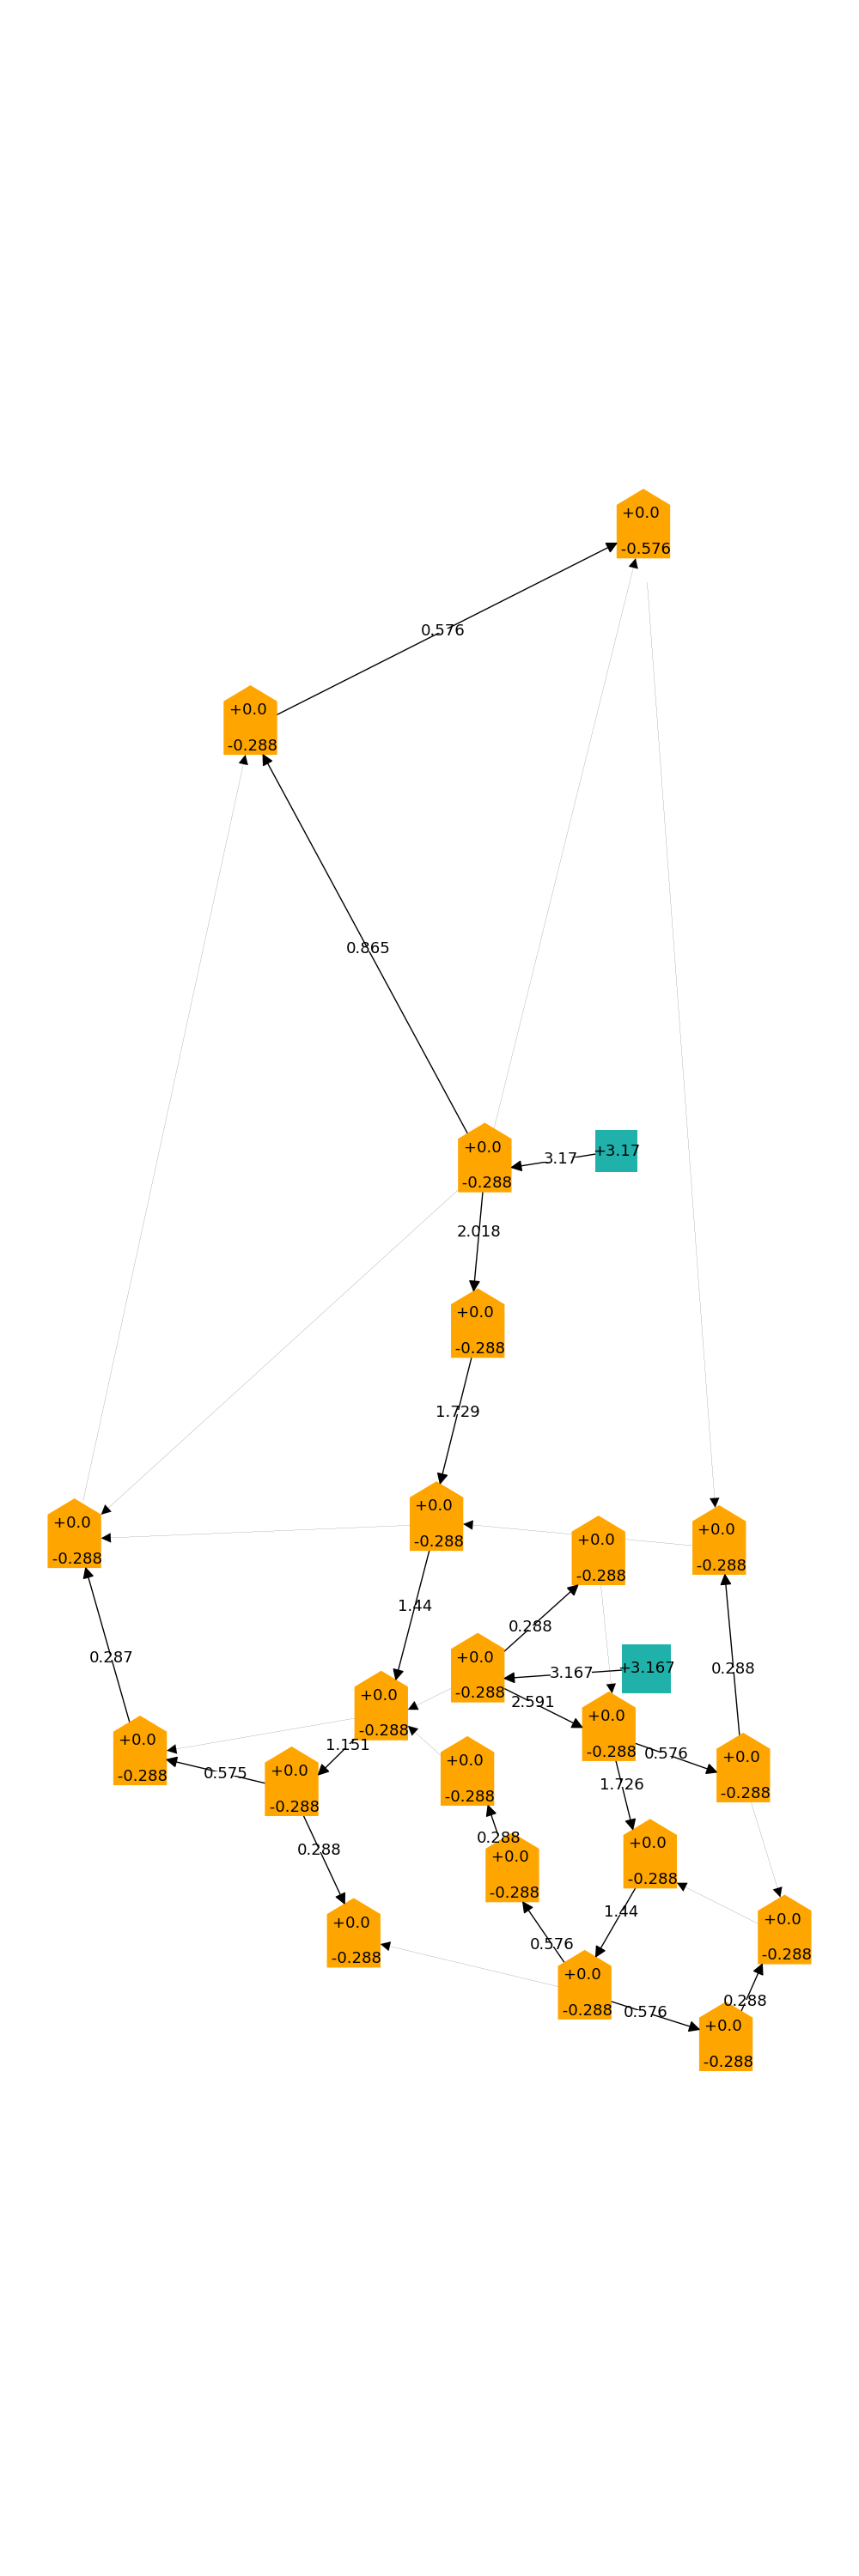

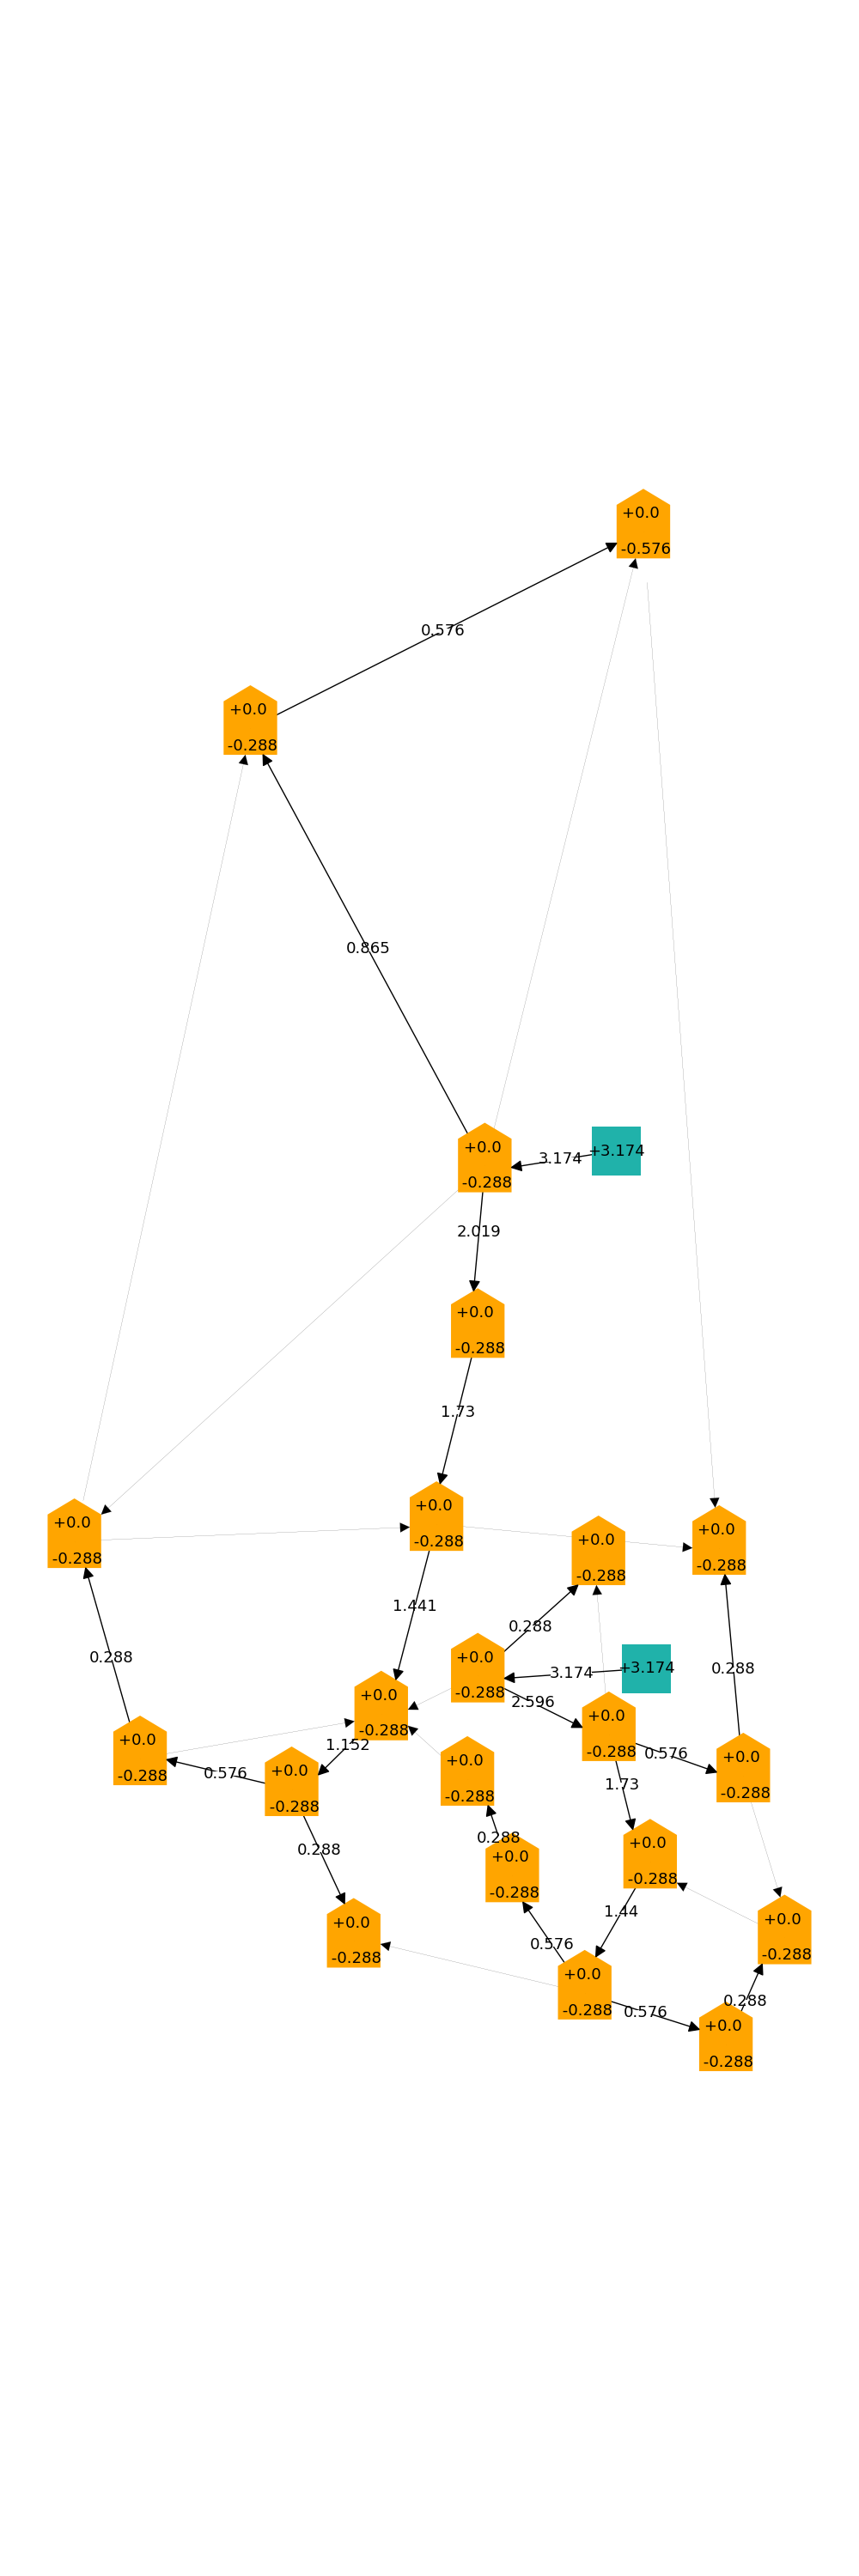

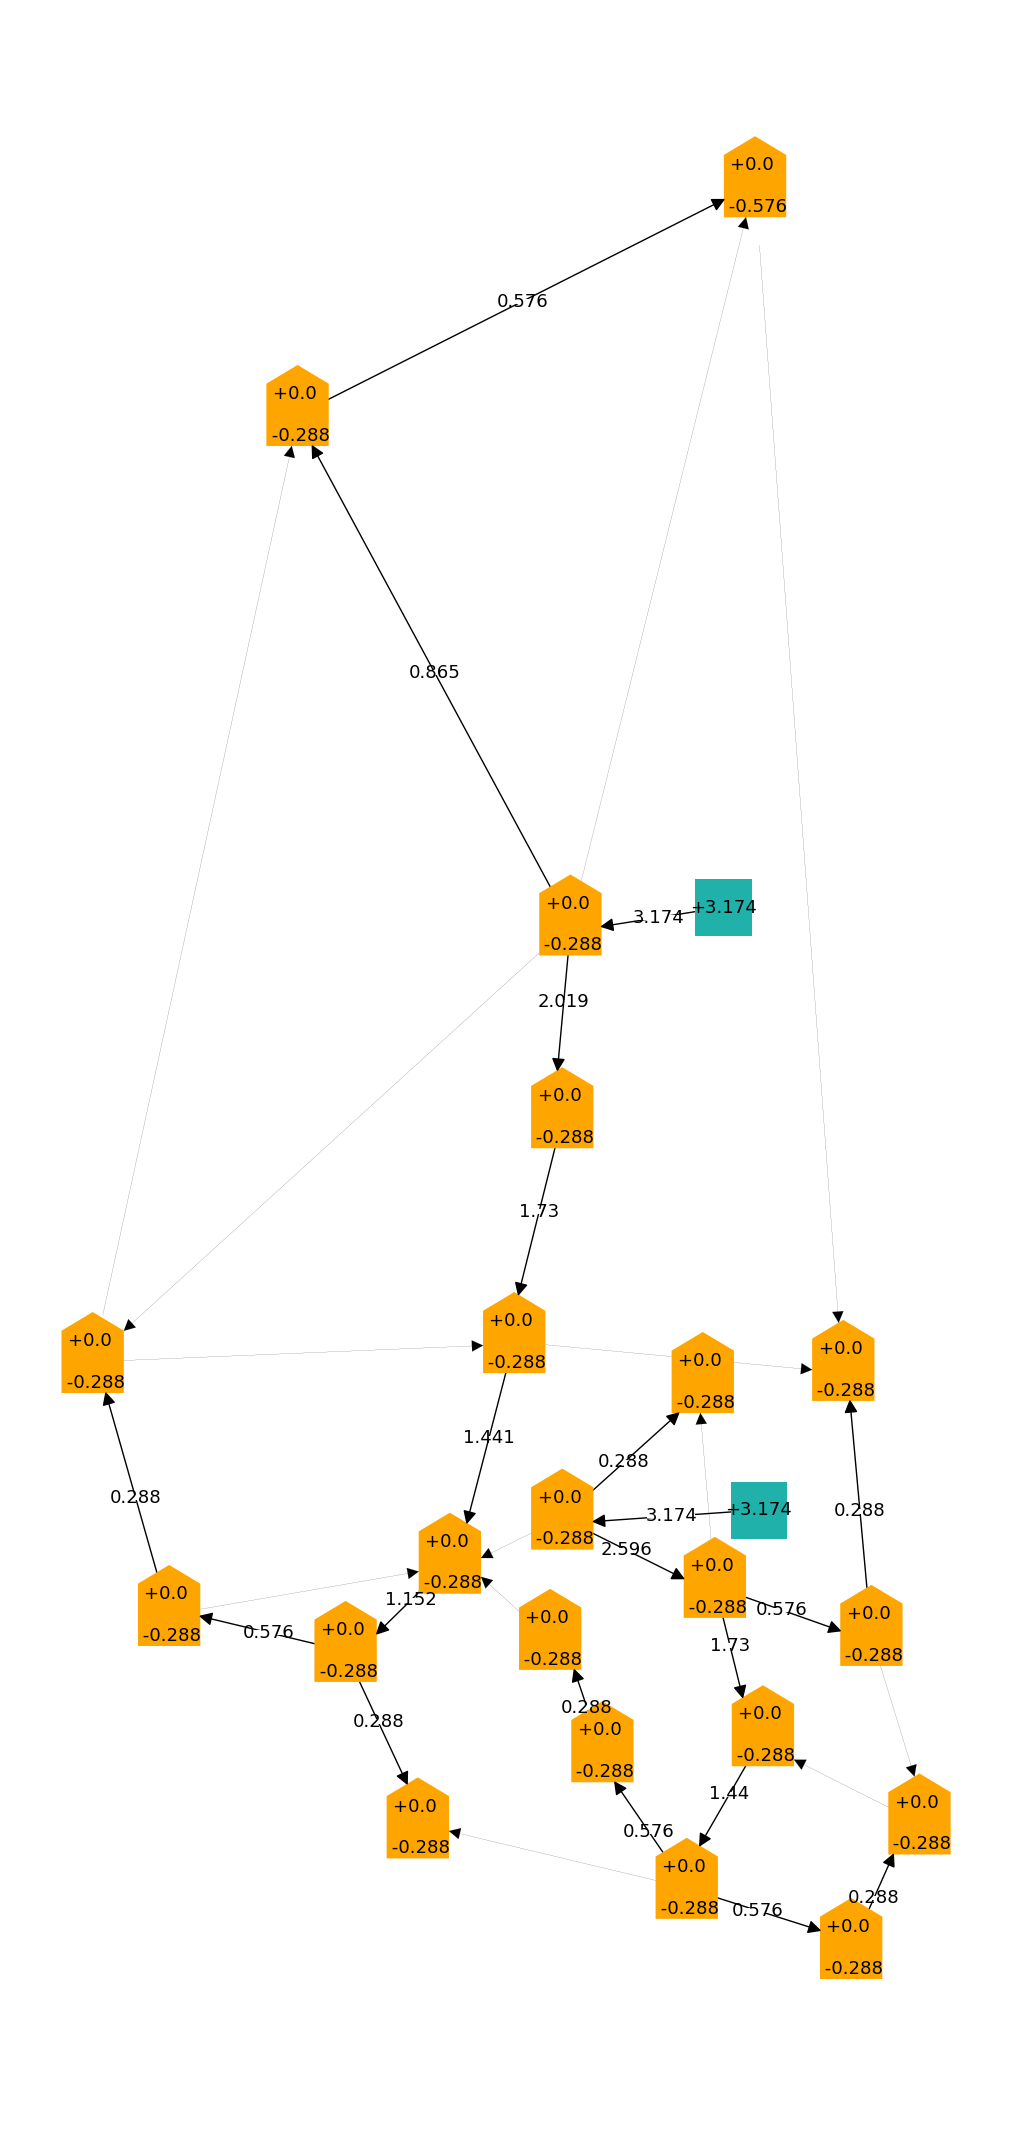

In [695]:
# -- PRINTING THE NETWORK --

pyplot()
print_network(length(N), length(Ns), line_ends, Jabr_var_values)
print_network(length(N), length(Ns), line_ends, BFM_var_values, jabr = false)

[comment]: <> (Section)
<hr style="color:#c6cde1;">
<p align="center">
    <b style="font-size:2vw; color:#c6cde1;">
    5. Functions that verify the results
    </b>
</p>
<hr style="color:#c6cde1;">

[comment]: <> (Description)
<p align="justify">
    In this section, one will be able to:
    <ul>
        <li style="margin-bottom:10px">Set the parameters that are required in the objective function;</li>
    </ul> 

In [ ]:
# -- JABR:  OPTIMALITY VERIFICATION --
@testset verbose = true "Checking optimality Jabr" begin
    P_G = Jabr_var_values["P_G"]
    Q_G = Jabr_var_values["Q_G"]
    S_G = Jabr_var_values["S_G"]
    X_i_ij  = Jabr_var_values["X_i_ij"]
    X_ij_re = Jabr_var_values["X_ij_re"]
    X_ij_im = Jabr_var_values["X_ij_im"]

    @testset "Conic constraints $i" for i in N
        @test S_G[i]^2 ≈ P_G[i]^2 + Q_G[i]^2
    end
    @testset "Rotated Conic constraints ($l, $k)" for l in L, k in K
        @test X_i_ij[l, k, line_ends[l][1]] * X_i_ij[l, k, line_ends[l][1]] ≈ X_ij_re[l, k]^2 + X_ij_im[l, k]^2
    end
end

In [ ]:
# -- BFM: OPTIMALITY VERIFICATION --

@testset verbose = true "Checking optimality BFM" begin
    P_G   = BFM_var_values["P_G"]
    Q_G   = BFM_var_values["Q_G"]
    S_G   = BFM_var_values["S_G"]
    P_ij  = BFM_var_values["P_ij"]
    Q_ij  = BFM_var_values["Q_ij"]
    V_sqr = BFM_var_values["V_sqr"]
    I_sqr = BFM_var_values["I_sqr"]
    
    @testset "Conic constraints $i" for i in N
        @test S_G[i]^2 ≈ P_G[i]^2 + Q_G[i]^2
    end
    @testset "Rotated Conic constraints ($l, $k)" for l in L
        @test V_sqr[line_ends[l][1]] * I_sqr[l] ≈ P_ij[l]^2 + Q_ij[l, k]^2
    end
end

In [ ]:
@testset verbose = true "Checking balance constraints" begin
    @testset "Conic constraints $i" for i in N
        @test S_G[i]^2 ≈ P_G[i]^2 + Q_G[i]^2
    end
    @testset "Rotated Conic constraints ($l, $k)" for l in L, k in K
        @test X_i_ij[l, k, line_ends[l][1]] * X_i_ij[l, k, line_ends[l][1]] ≈ X_ij_re[l, k]^2 + X_ij_im[l, k]^2
    end
end